In [ ]:
!pip3 install numpy

In [ ]:
!pip3 install pandas

In [ ]:
!pip3 install nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
!pip3 install matplotlib

In [ ]:
!pip3 install seaborn

In [ ]:
# extract the condition & topic & timestamps from the file name --> TO BE DONE
# example = open('./Conversation history/work-001.yml_1654740365554.txt', 'r')
# content = example.read()
# example.close()

In [68]:
from nltk import tokenize
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [69]:
def getStats(data_turn):
    total = sum(data_turn)
#     print(data_turn)
    turn_max = max(data_turn) if len(data_turn) > 0 else 0
    turn_min = min(data_turn) if len(data_turn) > 0 else 0
    turn_avg = np.average(data_turn) if len(data_turn) > 0 else 0
    return [total, turn_max, turn_min, turn_avg]

In [80]:
import pandas as pd
def getPd(condition, topic, content, path, email_id):
    
    # get dialogue starts
    dialog_num = content.find('[Dialog]') 
    dialog = content[dialog_num+9:]
    # remove one outlier
    dialog = dialog.replace('\n\n', ' ')
    # convert string to a list
    dialog_ls = dialog.split('\n')
    total_turns = len(dialog_ls)
    sys_turns = 0
    usr_turns = 0
    sys_sentences_turn = []
    sys_words_turn = []
    usr_sentences_turn = []
    usr_words_turn = []
    error_output = []

    # get the system dialogue
    sys_dialogues = []
    # get the user dialogues
    usr_dialogues = []
    
    if int(condition) > 4:
        condition = str(int(condition) - 4)
    
    ## get # of turns, word counts, and # of sentences per turn
#     print(dialog)
    for turn in dialog_ls:
        if turn[0] == 's':
            sys_turns += 1
            cur_turn = turn[8:]
            sys_sentences_turn.append(len(tokenize.sent_tokenize(cur_turn)))
            sys_words_turn.append(len(tokenizer.tokenize(cur_turn)))
            # append to the system dialogues:
            sys_dialogues.append(cur_turn)
        elif turn[0] == 'u':
            usr_turns += 1
            cur_turn = turn[6:]
            usr_sentences_turn.append(len(tokenize.sent_tokenize(cur_turn)))
            usr_words_turn.append(len(tokenizer.tokenize(cur_turn)))
        else:
            error_output.append(turn)
    

    total_words = len(tokenizer.tokenize(dialog)) - total_turns
    [sys_sentences_total, sys_sentences_max, sys_sentences_min, sys_sentences_avg] = getStats(sys_sentences_turn)
    [sys_words_total, sys_words_max, sys_words_min, sys_words_avg] = getStats(sys_words_turn)
    [usr_sentences_total, usr_sentences_max, usr_sentences_min, usr_sentences_avg] = getStats(usr_sentences_turn)
    [usr_words_total, usr_words_max, usr_words_min, usr_words_avg] = getStats(usr_words_turn)
    conv_stats = [condition, topic, path, total_turns, total_words, sys_turns, usr_turns, sys_sentences_total, \
                  sys_sentences_max, sys_sentences_min, sys_sentences_avg, sys_words_total, sys_words_max, \
                  sys_words_min, sys_words_avg, usr_sentences_total, usr_sentences_max, usr_sentences_min, \
                  usr_sentences_avg, usr_words_total, usr_words_max, usr_words_min, usr_words_avg, len(error_output), ' '.join(sys_dialogues)]
    columns = ['condition', 'topic', 'path', 'total_turns', 'total_words', 'sys_turns', 'usr_turns', \
               'sys_sentences_total', 'sys_sentences_max', 'sys_sentences_min', 'sys_sentences_avg', \
               'sys_words_total', 'sys_words_max', 'sys_words_min', 'sys_words_avg', 'usr_sentences_total', 
               'usr_sentences_max', 'usr_sentences_min', 'usr_sentences_avg', 'usr_words_total', 'usr_words_max', 
               'usr_words_min', 'usr_words_avg', 'error_counts', 'sys_dialogues']
    df = pd.DataFrame(conv_stats).transpose()
    df.columns = columns
    # save system response dialogues for furture conversations
    pd.DataFrame({'system': sys_dialogues}).to_csv("./System Response/{}_{}_{}_{}.csv".format(condition, topic, path, email_id), header=True)
    # output the system dialogues for analysis
    return df, usr_words_turn, sys_words_turn[1:]
    

In [81]:
import os, glob
import re
import numpy as np
import random
import string

data_df = pd.DataFrame()
# sys_dialogues = []
usr_words = []
sys_words = []

path = './Conversation history'
# loop through the whole folder
for filename in glob.glob(os.path.join(path, '*/*/*.txt')):
    read_filename = re.split('/',filename)[-1]
#     print(filename)
    email_id = re.split('/',filename)[2]
    read_info = re.split('_|\.', read_filename)
    condition = read_info[1]
    topic = read_info[0]
    path = read_info[2]
    with open(filename, 'r') as f:
        content = f.read()
        df, cur_usr_words, cur_sys_words = getPd(condition, topic, content, path, email_id)
        data_df = pd.concat([data_df, df])
        usr_words += cur_usr_words
        sys_words += cur_sys_words
        if 86 in cur_usr_words:
            print(filename)

./Conversation history/shinahoh@naver.com/1/sleep_1_positive.txt


ValueError: x and y must be the same size

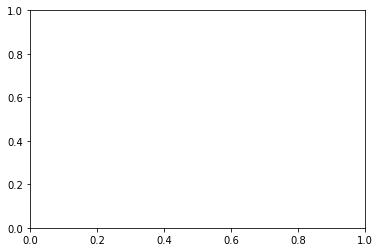

In [82]:
import matplotlib.pyplot as plt
plt.scatter(usr_words, sys_words)
ax = plt.gca()
ax.set_xlim([0, 40])

import scipy
from scipy import stats

r, p = scipy.stats.pearsonr(usr_words, sys_words)

print("The pearson correlation coefficient is:", r)
print("The p-value is:", p)

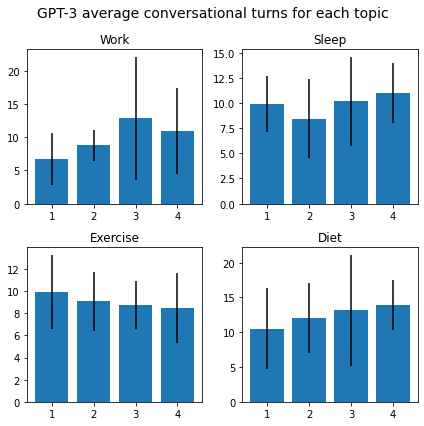

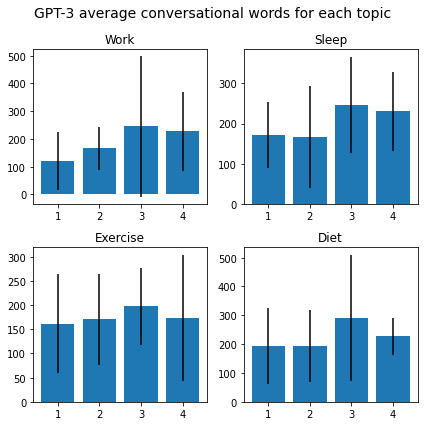

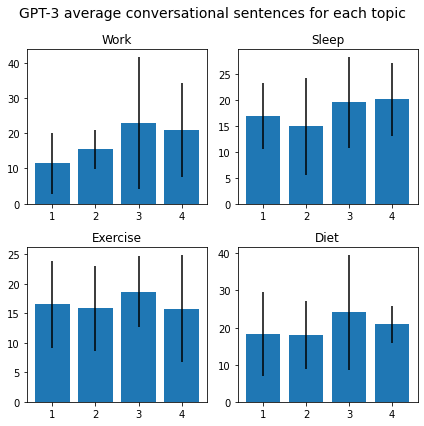

In [83]:


# prepare all the data for plotting
# we focus on three metrics: sys_turns, sys_sentences_total, sys_words_total
work_data = data_df[data_df['topic'] == 'work'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').mean().values
sleep_data = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').mean().values
exercise_data = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').mean().values
diet_data = data_df[data_df['topic'] == 'diet'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').mean().values
x_labels = ['1', '2', '3', '4']

## need to add std here
work_data_std = data_df[data_df['topic'] == 'work'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').std().values
sleep_data_std = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').std().values
exercise_data_std = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').std().values
diet_data_std = data_df[data_df['topic'] == 'diet'][['condition', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='condition').std().values
x_labels = ['1', '2', '3', '4']

# # we can group by path as well
# work_data_path_mean = data_df[data_df['topic'] == 'work'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').mean().values
# sleep_data_path_mean = data_df[data_df['topic'] == 'sleep'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').mean().values
# exercise_data_path_mean = data_df[data_df['topic'] == 'exercise'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').mean().values
# diet_data_path_mean = data_df[data_df['topic'] == 'diet'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').mean().values
# # std
# work_data_path_std = data_df[data_df['topic'] == 'work'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').std().values
# sleep_data_path_std = data_df[data_df['topic'] == 'sleep'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').std().values
# exercise_data_path_std = data_df[data_df['topic'] == 'exercise'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').std().values
# diet_data_path_std = data_df[data_df['topic'] == 'diet'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
#     .groupby(by='path').std().values

# path_labels = ['good', 'bad']
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
# fig.suptitle('GPT-3 average conversational turns for each topic, positive vs negative path', fontsize=14)
# axs[0,0].bar(path_labels, work_data_path_mean[:,0], yerr = work_data_path_std[:,0])
# axs[0,0].set_title('Work')
# axs[0,1].bar(path_labels, sleep_data_path_mean[:,0], yerr = sleep_data_path_std[:,0])
# axs[0,1].set_title('Sleep')
# axs[1,0].bar(path_labels, exercise_data_path_mean[:,0], yerr = exercise_data_path_std[:,0])
# axs[1,0].set_title('Exercise')
# axs[1,1].bar(path_labels, diet_data_path_mean[:,0], yerr = diet_data_path_std[:,0])
# axs[1,1].set_title('Diet')
# fig.tight_layout()

## 
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
fig.suptitle('GPT-3 average conversational turns for each topic', fontsize=14)
axs[0,0].bar(x_labels, work_data[:,0], yerr = work_data_std[:,0])
axs[0,0].set_title('Work')
axs[0,1].bar(x_labels, sleep_data[:,0], yerr = sleep_data_std[:,0])
axs[0,1].set_title('Sleep')
axs[1,0].bar(x_labels, exercise_data[:,0], yerr = exercise_data_std[:,0])
axs[1,0].set_title('Exercise')
axs[1,1].bar(x_labels, diet_data[:,0], yerr = diet_data_std[:,0])
axs[1,1].set_title('Diet')
fig.tight_layout()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
fig.suptitle('GPT-3 average conversational words for each topic', fontsize=14)
axs[0,0].bar(x_labels, work_data[:,1], yerr = work_data_std[:,1])
axs[0,0].set_title('Work')
axs[0,1].bar(x_labels, sleep_data[:,1], yerr = sleep_data_std[:,1])
axs[0,1].set_title('Sleep')
axs[1,0].bar(x_labels, exercise_data[:,1], yerr = exercise_data_std[:,1])
axs[1,0].set_title('Exercise')
axs[1,1].bar(x_labels, diet_data[:,1], yerr = diet_data_std[:,1])
axs[1,1].set_title('Diet')
fig.tight_layout()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
fig.suptitle('GPT-3 average conversational sentences for each topic', fontsize=14)
axs[0,0].bar(x_labels, work_data[:,2], yerr = work_data_std[:,2])
axs[0,0].set_title('Work')
axs[0,1].bar(x_labels, sleep_data[:,2], yerr = sleep_data_std[:,2])
axs[0,1].set_title('Sleep')
axs[1,0].bar(x_labels, exercise_data[:,2], yerr = exercise_data_std[:,2])
axs[1,0].set_title('Exercise')
axs[1,1].bar(x_labels, diet_data[:,2], yerr = diet_data_std[:,2])
axs[1,1].set_title('Diet')
fig.tight_layout()

Let's plot words/sentences per turn for the system.

Text(0.5, 1.0, 'Diet')

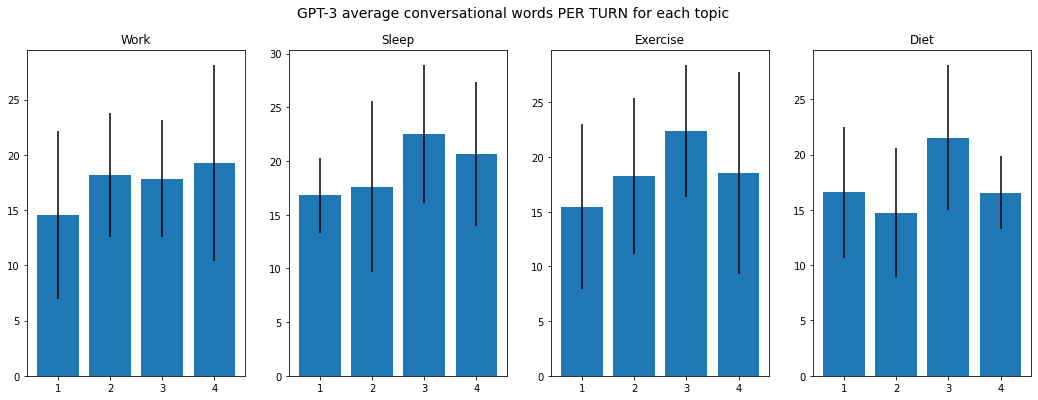

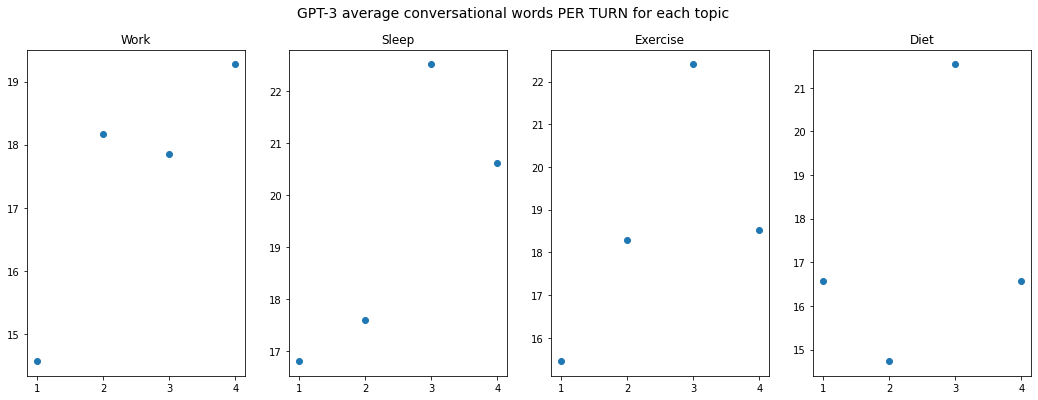

In [126]:

# prepare all the data for plotting
# we focus on three metrics: sys_turns, sys_sentences_total, sys_words_total
work_data = data_df[data_df['topic'] == 'work'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').mean().values
sleep_data = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').mean().values
exercise_data = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').mean().values
diet_data = data_df[data_df['topic'] == 'diet'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').mean().values
x_labels = ['1', '2', '3', '4']

## add std here
work_data_std = data_df[data_df['topic'] == 'work'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').std().values
sleep_data_std = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').std().values
exercise_data_std = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').std().values
diet_data_std = data_df[data_df['topic'] == 'diet'][['condition', 'sys_words_avg', 'sys_sentences_avg']]\
    .groupby(by='condition').std().values
x_labels = ['1', '2', '3', '4']

## plotting
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6), sharey=False)
fig.suptitle('GPT-3 average conversational words PER TURN for each topic', fontsize=14)
axs[0].bar(x_labels, work_data[:,0], yerr = work_data_std[:,0])
axs[0].set_title('Work')
axs[1].bar(x_labels, sleep_data[:,0], yerr = sleep_data_std[:,0])
axs[1].set_title('Sleep')
axs[2].bar(x_labels, exercise_data[:,0], yerr = exercise_data_std[:,0])
axs[2].set_title('Exercise')
axs[3].bar(x_labels, diet_data[:,0], yerr = diet_data_std[:,0])
axs[3].set_title('Diet')
# fig.tight_layout()



In [113]:
data_df[(data_df['topic'] == 'work') & (data_df['condition'] == '1')][['sys_words_avg', 'sys_sentences_avg']].mean()

sys_words_avg        14.573407
sys_sentences_avg     1.490326
dtype: float64

In [124]:
sleep_data

array([[16.81381975,  1.68200156],
       [17.60823413,  1.66316739],
       [22.51400868,  1.87044888],
       [20.62674191,  1.80961657]])

Plot - we can group by path as well

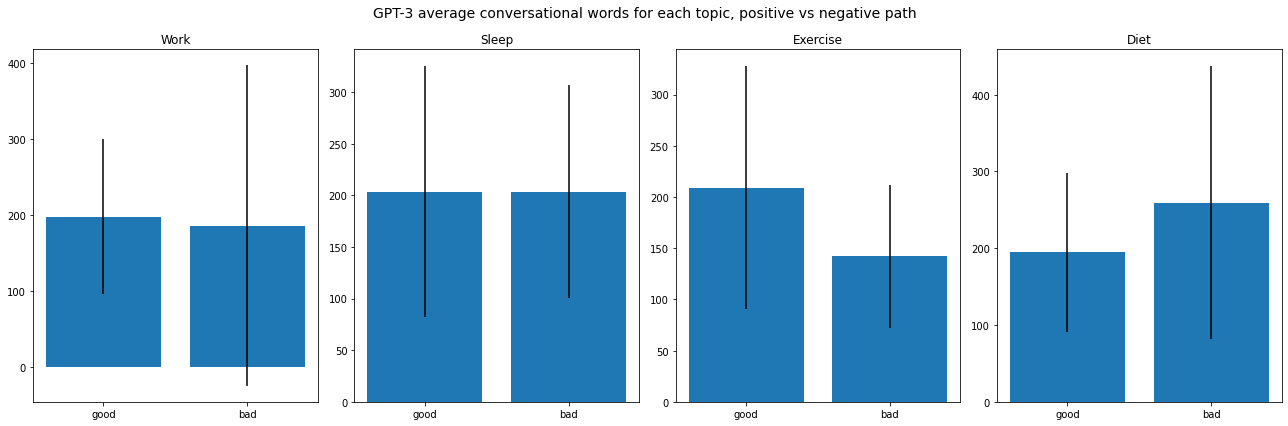

In [91]:
work_data_path_mean = data_df[data_df['topic'] == 'work'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').mean().values
sleep_data_path_mean = data_df[data_df['topic'] == 'sleep'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').mean().values
exercise_data_path_mean = data_df[data_df['topic'] == 'exercise'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').mean().values
diet_data_path_mean = data_df[data_df['topic'] == 'diet'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').mean().values
# std
work_data_path_std = data_df[data_df['topic'] == 'work'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').std().values
sleep_data_path_std = data_df[data_df['topic'] == 'sleep'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').std().values
exercise_data_path_std = data_df[data_df['topic'] == 'exercise'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').std().values
diet_data_path_std = data_df[data_df['topic'] == 'diet'][['path', 'sys_turns', 'sys_words_total', 'sys_sentences_total']]\
    .groupby(by='path').std().values

# path_labels = ['good', 'bad']
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
# fig.suptitle('GPT-3 average conversational turns for each topic, positive vs negative path', fontsize=14)
# axs[0,0].bar(path_labels, work_data_path_mean[:,0], yerr = work_data_path_std[:,0])
# axs[0,0].set_title('Work')
# axs[0,1].bar(path_labels, sleep_data_path_mean[:,0], yerr = sleep_data_path_std[:,0])
# axs[0,1].set_title('Sleep')
# axs[1,0].bar(path_labels, exercise_data_path_mean[:,0], yerr = exercise_data_path_std[:,0])
# axs[1,0].set_title('Exercise')
# axs[1,1].bar(path_labels, diet_data_path_mean[:,0], yerr = diet_data_path_std[:,0])
# axs[1,1].set_title('Diet')
# fig.tight_layout()

path_labels = ['good', 'bad']
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6), sharey=False)
fig.suptitle('GPT-3 average conversational words for each topic, positive vs negative path', fontsize=14)
axs[0].bar(path_labels, work_data_path_mean[:,1], yerr = work_data_path_std[:,1])
axs[0].set_title('Work')
axs[1].bar(path_labels, sleep_data_path_mean[:,1], yerr = sleep_data_path_std[:,1])
axs[1].set_title('Sleep')
axs[2].bar(path_labels, exercise_data_path_mean[:,1], yerr = exercise_data_path_std[:,1])
axs[2].set_title('Exercise')
axs[3].bar(path_labels, diet_data_path_mean[:,1], yerr = diet_data_path_std[:,1])
axs[3].set_title('Diet')
fig.tight_layout()

In [8]:
data_df

,condition,topic,path,total_turns,total_words,sys_turns,usr_turns,sys_sentences_total,sys_sentences_max,sys_sentences_min,...,usr_sentences_total,usr_sentences_max,usr_sentences_min,sys_sentences_avg,usr_words_total,usr_words_max,usr_words_min,usr_words_avg,error_counts,sys_dialogues
0,1,exercise,positive,15,108,8,7,12,3,1,...,8,2,1,1.142857,36,12,1,5.142857,0,How's your day so far? What workout did you do...
0,1,sleep,positive,15,167,8,7,12,2,1,...,7,1,1,1.0,37,14,1,5.285714,0,"How's your day so far? So, what time did you g..."
0,1,work,negative,13,126,7,6,10,2,1,...,6,1,1,1.0,31,8,1,5.166667,0,How's your day so far? Can you tell me about y...
0,1,diet,negative,11,95,6,5,6,1,1,...,5,1,1,1.0,30,13,1,6.0,0,How's your day so far? Can you tell me what yo...
0,1,diet,positive,25,361,13,12,25,3,1,...,13,2,1,1.083333,88,16,3,7.333333,0,How's your day so far? What did you have for b...
0,1,work,positive,1,6,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,How's your day so far?
0,1,sleep,negative,21,254,11,10,19,5,1,...,10,1,1,1.0,46,11,1,4.6,0,How's your day so far? What time did you go to...
0,1,exercise,negative,17,226,9,8,17,3,1,...,9,2,1,1.125,51,14,1,6.375,0,How's your day so far? What workout did you do...
0,1,exercise,positive,17,208,9,8,13,3,1,...,8,1,1,1.0,76,25,2,9.5,0,How's your day so far? What workout did you do...
0,1,sleep,positive,17,163,9,8,16,3,0,...,9,2,1,1.125,37,13,1,4.625,0,How's your day so far? That's fantastic! Now I...


Let's see how many words were given by users

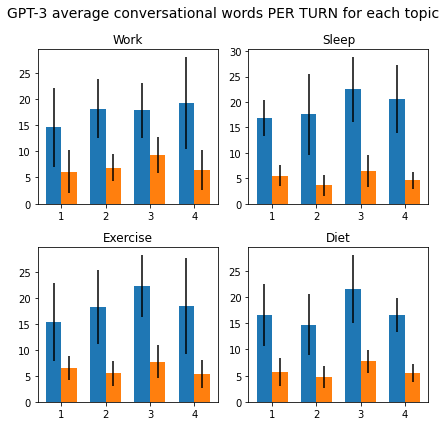

In [128]:
x_labels = ['1', '2', '3', '4']
x = np.arange(len(x_labels))
width = 0.35

work_data = data_df[data_df['topic'] == 'work'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').mean().values
sleep_data = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').mean().values
exercise_data = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').mean().values
diet_data = data_df[data_df['topic'] == 'diet'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').mean().values


## need to add std here
work_data_std = data_df[data_df['topic'] == 'work'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').std().values
sleep_data_std = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').std().values
exercise_data_std = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').std().values
diet_data_std = data_df[data_df['topic'] == 'diet'][['condition', 'sys_words_avg', 'usr_words_avg']]\
    .groupby(by='condition').std().values


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
fig.suptitle('GPT-3 average conversational words PER TURN for each topic', fontsize=14)
axs[0,0].bar(x - width/2, work_data[:,0], width, yerr = work_data_std[:,0], label='System')
axs[0,0].bar(x + width/2, work_data[:,1], width, yerr = work_data_std[:,1], label = 'User')
axs[0,0].set_title('Work')
axs[0,0].set_xticks(x, x_labels)
axs[0,1].bar(x - width/2, sleep_data[:,0], width, yerr = sleep_data_std[:,0], label = 'System')
axs[0,1].bar(x + width/2, sleep_data[:,1], width, yerr = sleep_data_std[:,1], label = 'User')
axs[0,1].set_title('Sleep')
axs[0,1].set_xticks(x, x_labels)
axs[1,0].bar(x - width/2, exercise_data[:,0], width, yerr = exercise_data_std[:,0], label = 'System')
axs[1,0].bar(x + width/2, exercise_data[:,1], width, yerr = exercise_data_std[:,1], label = 'User')
axs[1,0].set_title('Exercise')
axs[1,0].set_xticks(x, x_labels)
axs[1,1].bar(x - width/2, diet_data[:,0], width, yerr = diet_data_std[:,0], label = 'System')
axs[1,1].bar(x + width/2, diet_data[:,1], width, yerr = diet_data_std[:,1], label = 'User')
axs[1,1].set_title('Diet')
axs[1,1].set_xticks(x, x_labels)
fig.tight_layout()


In [132]:
diet_data

array([[16.56633128,  5.71675685],
       [14.74158179,  4.79034891],
       [21.53415567,  7.73802226],
       [16.56381121,  5.50257026]])

Text(0.5, 1.0, 'Diet')

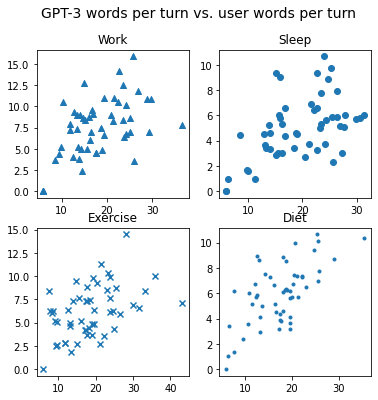

In [94]:
work_data = data_df[data_df['topic'] == 'work'][['condition', 'sys_words_avg', 'usr_words_avg', 'sys_sentences_avg', 'usr_sentences_avg']]
sleep_data = data_df[data_df['topic'] == 'sleep'][['condition', 'sys_words_avg', 'usr_words_avg', 'sys_sentences_avg', 'usr_sentences_avg']]
exercise_data = data_df[data_df['topic'] == 'exercise'][['condition', 'sys_words_avg', 'usr_words_avg', 'sys_sentences_avg', 'usr_sentences_avg']]
diet_data = data_df[data_df['topic'] == 'diet'][['condition', 'sys_words_avg', 'usr_words_avg', 'sys_sentences_avg', 'usr_sentences_avg']]

work_data_1 = work_data[work_data['condition'] == '1']


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
fig.suptitle('GPT-3 words per turn vs. user words per turn', fontsize=14)
axs[0,0].scatter(work_data['sys_words_avg'].values, work_data['usr_words_avg'].values, marker='^')
axs[0,0].set_title('Work')
axs[0,1].scatter(sleep_data['sys_words_avg'].values, sleep_data['usr_words_avg'].values, marker='o')
axs[0,1].set_title('Sleep')
axs[1,0].scatter(exercise_data['sys_words_avg'].values, exercise_data['usr_words_avg'].values, marker='x')
axs[1,0].set_title('Exercise')
axs[1,1].scatter(diet_data['sys_words_avg'].values, diet_data['usr_words_avg'].values, marker='.')
axs[1,1].set_title('Diet')


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=False)
# fig.suptitle('GPT-3 sentences per turn vs. user sentences per turn', fontsize=14)
# axs[0,0].scatter(work_data['sys_sentences_avg'].values, work_data['usr_sentences_avg'].values, marker='^')
# axs[0,0].set_title('Work')
# axs[0,1].scatter(sleep_data['sys_sentences_avg'].values, sleep_data['usr_sentences_avg'].values, marker='o')
# axs[0,1].set_title('Sleep')
# axs[1,0].scatter(exercise_data['sys_sentences_avg'].values, exercise_data['usr_sentences_avg'].values, marker='x')
# axs[1,0].set_title('Exercise')
# axs[1,1].scatter(diet_data['sys_sentences_avg'].values, diet_data['usr_sentences_avg'].values, marker='.')
# axs[1,1].set_title('Diet')

In [44]:
data_df['sys_dialogues']

0    How's your day so far? What workout did you do...
0    How's your day so far? So, what time did you g...
0    How's your day so far? Can you tell me about y...
0    How's your day so far? Can you tell me what yo...
0    How's your day so far? What did you have for b...
                           ...                        
0    How's your day so far? What work were you able...
0    How's your day so far? What work did you do ye...
0    How's your day so far? How was your breakfast ...
0    How's your day so far? What workout did you do...
0    How's your day so far? When did you go to bed ...
Name: sys_dialogues, Length: 96, dtype: object

Get the word frequency from system responses.

[Text(0.5, 1.0, 'Work - 4')]

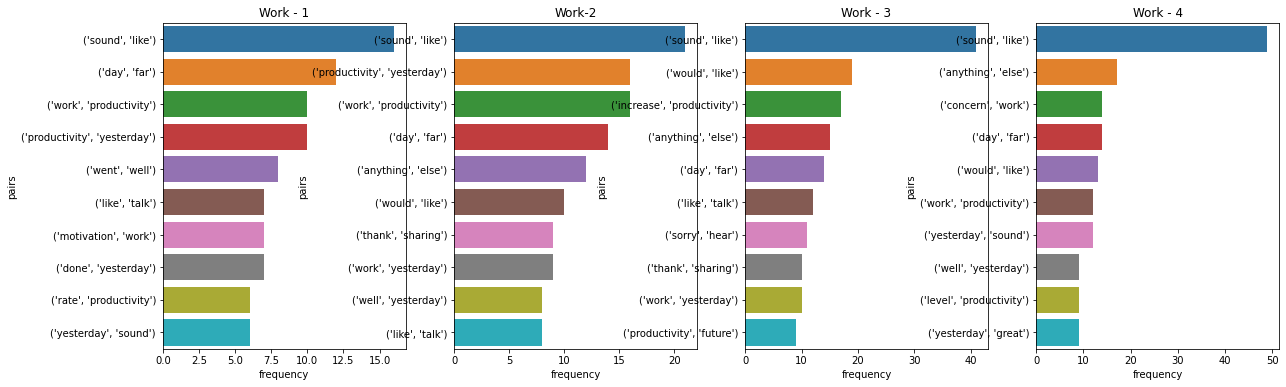

In [135]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def word_frequency(sentence):
    # joins all the sentenses
    sentence =" ".join(sentence)
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

# work - 1
work_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'work')]['sys_dialogues'].values
# work - 2
work_data_2 = data_df[(data_df['condition'] == '2') & (data_df['topic'] == 'work')]['sys_dialogues'].values
# work - 3
work_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'work')]['sys_dialogues'].values
# work - 4
work_data_4 = data_df[(data_df['condition'] == '4') & (data_df['topic'] == 'work')]['sys_dialogues'].values

data2, data3, data4 = word_frequency(work_data_1)

# create subplot of the different data frames
fig, axes = plt.subplots(1,4,figsize=(20,6))
sns.barplot(ax=axes[0],x='frequency',y='pairs',data=data3.head(10)).set(title='Work - 1')
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))


data2, data3, data4 = word_frequency(work_data_2)
sns.barplot(ax=axes[1], x='frequency', y='pairs', data=data3.head(10)).set(title='Work-2')


data2, data3, data4 = word_frequency(work_data_3)

# create subplot of the different data frames
# fig, axes = plt.subplots(3,1,figsize=(8,20))
# fig, axes = plt.subplots(1,1,figsize=(8,20))
sns.barplot(ax=axes[2],x='frequency',y='pairs',data=data3.head(10)).set(title='Work - 3')

data2, data3, data4 = word_frequency(work_data_4)
sns.barplot(ax=axes[3], x='frequency', y='pairs', data = data3.head(10)).set(title='Work - 4')
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))
# # plt.rcParams["axes.labelsize"] = 20

# # exercise - 1
# exercise_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'exercise')]['sys_dialogues'].values
# # exercise - 3
# exercise_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'exercise')]['sys_dialogues'].values

# data2, data3, data4 = word_frequency(exercise_data_1)
# fig, axes = plt.subplots(1,2,figsize=(20,10))
# sns.barplot(ax=axes[0],x='frequency',y='word',data=data2.head(15)).set(title='Exercise - 1')
# data2, data3, data4 = word_frequency(exercise_data_3)
# sns.barplot(ax=axes[1],x='frequency',y='word',data=data2.head(15)).set(title='Exercise - 3')


# # sleep - 1
# sleep_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values
# # sleep - 3
# sleep_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values

# data2, data3, data4 = word_frequency(sleep_data_1)
# fig, axes = plt.subplots(1,2,figsize=(20,10))
# sns.barplot(ax=axes[0],x='frequency',y='word',data=data2.head(15)).set(title='Sleep - 1')
# data2, data3, data4 = word_frequency(sleep_data_3)
# sns.barplot(ax=axes[1],x='frequency',y='word',data=data2.head(15)).set(title='Sleep - 3')


# # diet - 1
# diet_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'diet')]['sys_dialogues'].values
# # diet - 3
# diet_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'diet')]['sys_dialogues'].values

# data2, data3, data4 = word_frequency(diet_data_1)
# fig, axes = plt.subplots(1,2,figsize=(20,10))
# sns.barplot(ax=axes[0],x='frequency',y='word',data=data2.head(15)).set(title='Diet - 1')
# data2, data3, data4 = word_frequency(diet_data_3)
# sns.barplot(ax=axes[1],x='frequency',y='word',data=data2.head(15)).set(title='Diet - 3')


[Text(0, 0.5, '')]

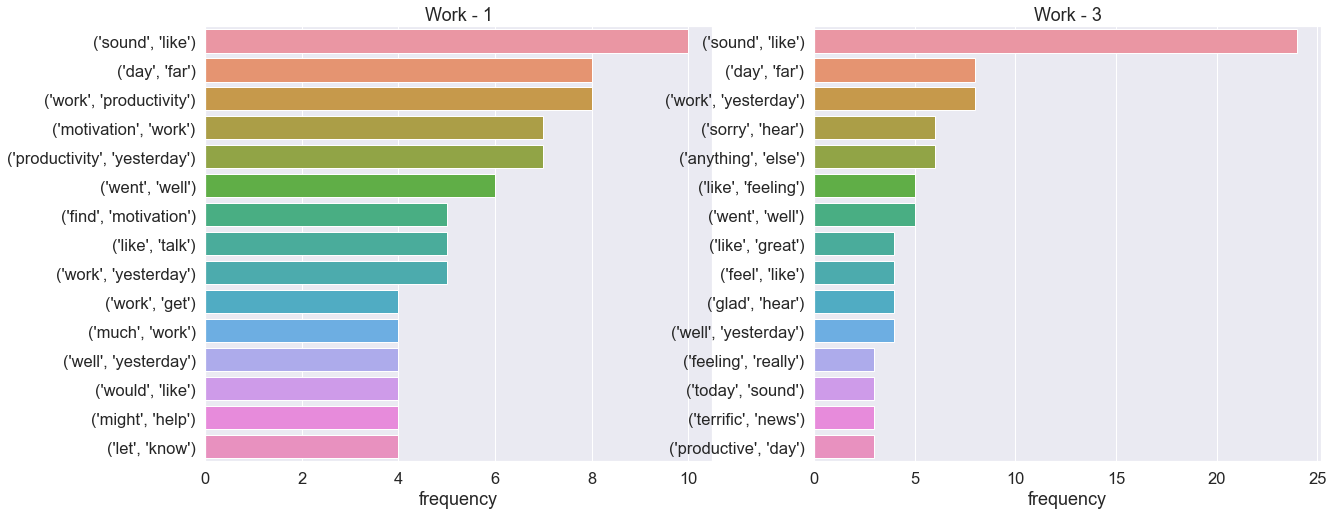

In [23]:
work_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'work')]['sys_dialogues'].values
# work - 3
work_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'work')]['sys_dialogues'].values

data2, data3, data4 = word_frequency(work_data_1)

# create subplot of the different data frames
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.set(font_scale = 1.5)
# plt.rcParams["axes.labelsize"] = 40
g1 = sns.barplot(ax=axes[0],x='frequency',y='pairs',data=data3.head(15))
g1.set(title='Work - 1')
g1.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

data2, data3, data4 = word_frequency(work_data_3)

# create subplot of the different data frames
# fig, axes = plt.subplots(3,1,figsize=(8,20))
# fig, axes = plt.subplots(1,1,figsize=(8,20))
g2 = sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(15))
g2.set(title='Work - 3')
g2.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))


[Text(0, 0.5, '')]

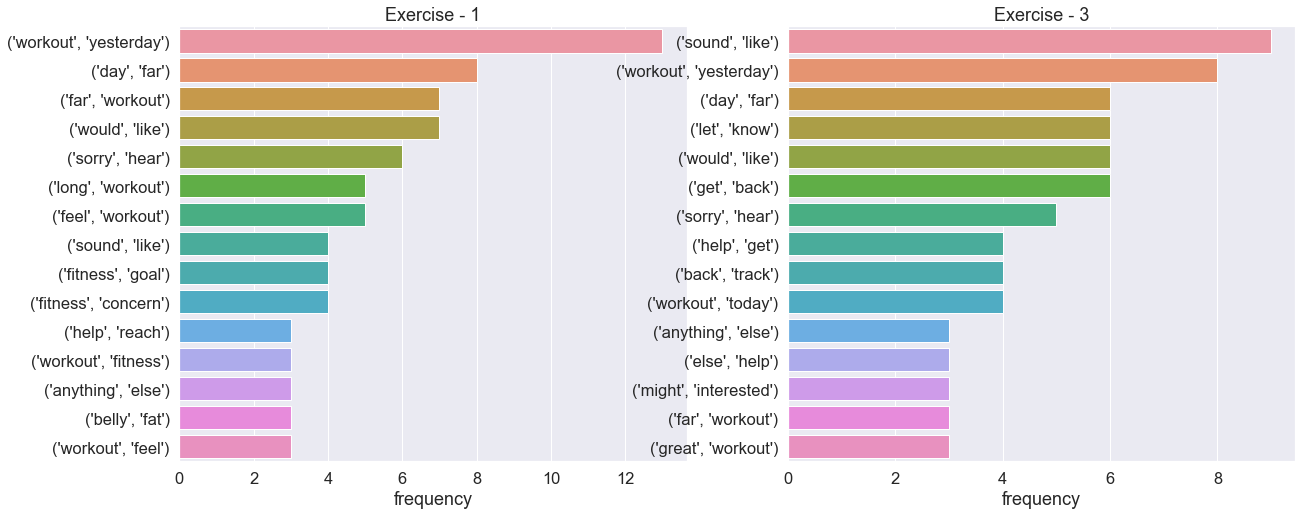

In [24]:
exercise_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'exercise')]['sys_dialogues'].values
# work - 3
exercise_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'exercise')]['sys_dialogues'].values

data2, data3, data4 = word_frequency(exercise_data_1)

# create subplot of the different data frames
fig, axes = plt.subplots(1,4,figsize=(20,8))
sns.set(font_scale = 1.5)
# plt.rcParams["axes.labelsize"] = 40
g1 = sns.barplot(ax=axes[0],x='frequency',y='pairs',data=data3.head(15))
g1.set(title='Exercise - 1')
g1.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

data2, data3, data4 = word_frequency(exercise_data_3)

# create subplot of the different data frames
# fig, axes = plt.subplots(3,1,figsize=(8,20))
# fig, axes = plt.subplots(1,1,figsize=(8,20))
g2 = sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(15))
g2.set(title='Exercise - 3')
g2.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))


[Text(0, 0.5, '')]

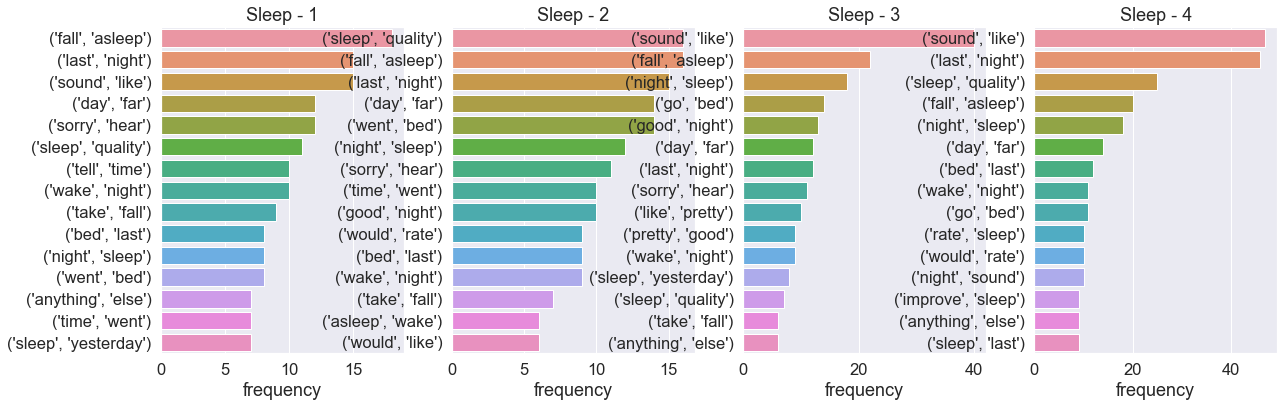

In [138]:
sleep_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values
sleep_data_2 = data_df[(data_df['condition'] == '2') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values
sleep_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values
sleep_data_4 = data_df[(data_df['condition'] == '4') & (data_df['topic'] == 'sleep')]['sys_dialogues'].values

data2, data3, data4 = word_frequency(sleep_data_1)

# create subplot of the different data frames
fig, axes = plt.subplots(1,4,figsize=(20,6))
sns.set(font_scale = 1.5)
# plt.rcParams["axes.labelsize"] = 40
g1 = sns.barplot(ax=axes[0],x='frequency',y='pairs',data=data3.head(15))
g1.set(title='Sleep - 1')
g1.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

data2, data3, data4 = word_frequency(sleep_data_2)
g1 = sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(15))
g1.set(title='Sleep - 2')
g1.set(ylabel=None)

data2, data3, data4 = word_frequency(sleep_data_3)
g1 = sns.barplot(ax=axes[2],x='frequency',y='pairs',data=data3.head(15))
g1.set(title='Sleep - 3')
g1.set(ylabel=None)

data2, data3, data4 = word_frequency(sleep_data_4)

# create subplot of the different data frames
# fig, axes = plt.subplots(3,1,figsize=(8,20))
# fig, axes = plt.subplots(1,1,figsize=(8,20))
g2 = sns.barplot(ax=axes[3],x='frequency',y='pairs',data=data3.head(15))
g2.set(title='Sleep - 4')
g2.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))


[Text(0, 0.5, '')]

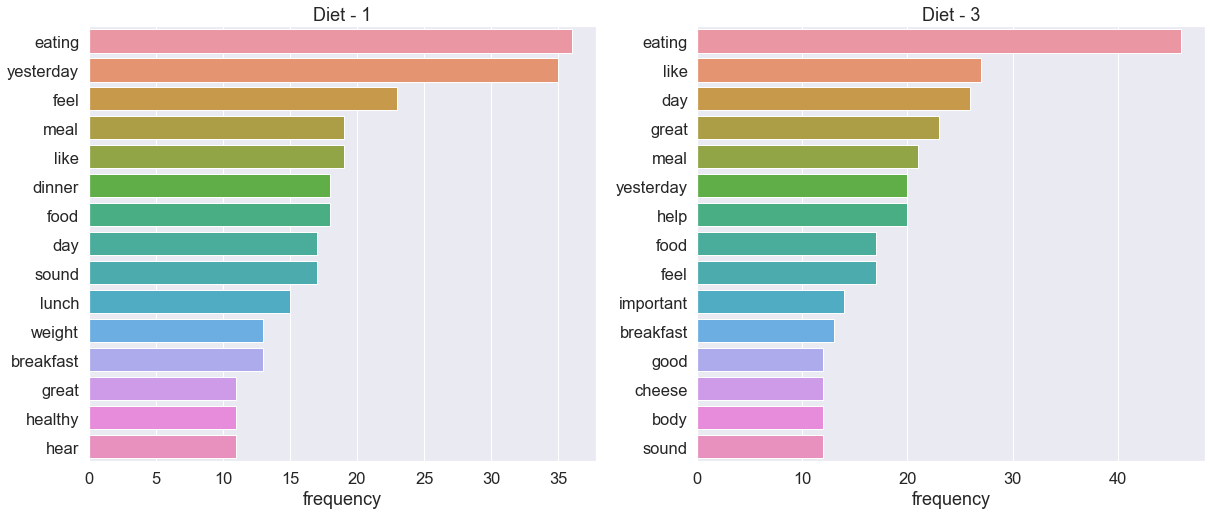

In [26]:
diet_data_1 = data_df[(data_df['condition'] == '1') & (data_df['topic'] == 'diet')]['sys_dialogues'].values
# work - 3
diet_data_3 = data_df[(data_df['condition'] == '3') & (data_df['topic'] == 'diet')]['sys_dialogues'].values

data2, data3, data4 = word_frequency(diet_data_1)

# create subplot of the different data frames
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.set(font_scale = 1.5)
# plt.rcParams["axes.labelsize"] = 40
g1 = sns.barplot(ax=axes[0],x='frequency',y='word',data=data2.head(15))
g1.set(title='Diet - 1')
g1.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

data2, data3, data4 = word_frequency(diet_data_3)

# create subplot of the different data frames
# fig, axes = plt.subplots(3,1,figsize=(8,20))
# fig, axes = plt.subplots(1,1,figsize=(8,20))
g2 = sns.barplot(ax=axes[1],x='frequency',y='word',data=data2.head(15))
g2.set(title='Diet - 3')
g2.set(ylabel=None)
# sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
# sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))


Below is the visualization of manual labelled data.

In [ ]:
# let's write some codes to analyze the user behavior